<a href="https://colab.research.google.com/github/HarikrishnaYashoda/Failed-orders-insights/blob/main/Failed_orders_insights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Assignment**

Please complete the following tasks.

Build up distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

Plot the average time to cancellation with and without driver, by the hour. If there are any outliers in the data, it would be better to remove them. Can we draw any conclusions from this plot?

Plot the distribution of average ETA by hours. How can this plot be explained?

BONUS Hexagons. Using the h3 and folium packages, calculate how many sizes 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

**Read and Explore the Datasets**

In [1]:
import pandas as pd

In [2]:
orders = pd.read_csv(filepath_or_buffer="data_orders.csv")

In [3]:
# rows, columns
orders.shape

(10716, 8)

In [4]:
# the random_state argument ensures that we get the same sample
# each time we call the method with the same arguments
orders.sample(n=10, random_state=42)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
10309,00:29:14,-0.966062,51.454821,NaN,3000555146103,4,0,44.0
6705,01:28:45,-0.970472,51.456725,NaN,3000595870644,4,0,121.0
304,08:22:36,-0.916708,51.439852,NaN,3000627783633,9,0,NaN
9143,07:32:27,-0.955580,51.453493,1078.0,3000622140805,4,1,1017.0
10593,04:39:55,-0.946358,51.439779,NaN,3000554645524,4,0,121.0
8654,08:05:02,-0.967327,51.449395,598.0,3000592772077,4,1,48.0
3919,00:21:47,-0.971597,51.457574,NaN,3000624492441,4,0,180.0
4337,20:26:40,-0.971296,51.458115,NaN,3000628755869,4,0,104.0
6931,07:25:39,-0.942301,51.474812,NaN,3000628430595,4,0,44.0
967,13:41:31,-0.952194,51.444067,NaN,3000623591189,9,0,NaN


In [5]:
offers = pd.read_csv(filepath_or_buffer="data_offers.csv")

In [6]:
offers.shape

(334363, 2)

In [7]:
offers.sample(n=10, random_state=42)

,order_gk,offer_id
244971,3000627481054,300052086404
236783,3000631282042,300052342376
22714,3000624367715,300051909011
306983,3000557436646,300050769980
170256,3000588131807,300051201442
316173,3000629756224,300052250019
234398,3000625018320,300051967737
122107,3000629082264,300052196687
60909,3000588606991,300051225443
52998,3000629981908,300052274857


Next, we would like to merge the two DataFrames into one, for easier manipulation. Pandas has the merge() method for doing exactly that. It is similar to joining tables in SQL. We specify how we want the merge to be carried out (inner) and on which column should it occur (order_gk). Then, we print a sample of the merged DataFrame.

In [8]:
df = orders.merge(right=offers, how="inner", on="order_gk")

In [9]:
df.sample(n=10, random_state=42)

,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
30194,21:15:35,-0.969588,51.455780,299.0,3000555697076,4,1,223.0,300050725946
14748,10:13:35,-0.955958,51.430362,NaN,3000626091676,4,0,91.0,300052014519
29083,09:16:38,-1.033560,51.441967,NaN,3000594099225,4,0,68.0,300051458740
16926,02:08:09,-0.967676,51.444489,NaN,3000626980467,4,0,125.0,300052031394
21530,21:44:21,-0.972683,51.456762,NaN,3000554421440,4,0,11.0,300050671163
13008,03:03:45,-0.966745,51.453236,NaN,3000593295623,9,0,NaN,300051413313
2034,14:41:22,-0.948642,51.449587,NaN,3000584916226,4,0,6.0,300051090742
2229,20:54:03,-0.991382,51.476339,NaN,3000585716553,9,0,NaN,300051125957
16632,18:06:17,-0.948907,51.444643,NaN,3000627382471,4,0,113.0,300052078801
18189,07:52:29,-0.973793,51.458665,479.0,3000587781360,4,1,47.0,300051178628


We may be able to do something to improve the data quality a bit. For example, the values in order_status_key and is_driver_assigned_key are not informative of the contents but are rather just keys that point to some internal description. We could replace their values with more informative information, like replacing the 1s in is_driver_assigned_key with the string Yes and the 0s with the string No. The same can be done for the order_status_key column. Moreover, the names of the columns sound a bit technical, but we can modify them.

In [10]:
import numpy as np

df["is_driver_assigned"] = np.where(df["is_driver_assigned_key"] == 1, "Yes", "No")
df["order_status"] = np.where(df["order_status_key"] == 4, "Client Cancelled", "System Reject")

df.drop(columns=["is_driver_assigned_key", "order_status_key"], inplace=True)

In [11]:
df = df.rename(columns={
    "order_datetime": "order_time"
})

In [12]:
df.sample(n=10, random_state=42)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status
30194,21:15:35,-0.969588,51.455780,299.0,3000555697076,223.0,300050725946,Yes,Client Cancelled
14748,10:13:35,-0.955958,51.430362,NaN,3000626091676,91.0,300052014519,No,Client Cancelled
29083,09:16:38,-1.033560,51.441967,NaN,3000594099225,68.0,300051458740,No,Client Cancelled
16926,02:08:09,-0.967676,51.444489,NaN,3000626980467,125.0,300052031394,No,Client Cancelled
21530,21:44:21,-0.972683,51.456762,NaN,3000554421440,11.0,300050671163,No,Client Cancelled
13008,03:03:45,-0.966745,51.453236,NaN,3000593295623,NaN,300051413313,No,System Reject
2034,14:41:22,-0.948642,51.449587,NaN,3000584916226,6.0,300051090742,No,Client Cancelled
2229,20:54:03,-0.991382,51.476339,NaN,3000585716553,NaN,300051125957,No,System Reject
16632,18:06:17,-0.948907,51.444643,NaN,3000627382471,113.0,300052078801,No,Client Cancelled
18189,07:52:29,-0.973793,51.458665,479.0,3000587781360,47.0,300051178628,Yes,Client Cancelled


**Question 1**

*Build up a distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?*

One, straightforward solution to solve this question is to use the groupby method to group the DataFrame by the is_driver_assigned and order_status columns, and then count the rows in each group, i.e., each combination of values for the grouping columns.

Since both are binary variables (have only two possible values), there are four possible combinations. The cell below prints the output of the proposed approach.

We observe a high number of orders cancelled before a driver is assigned, implying that maybe customers have waited too long and have decided on an alternative for their transportation needs. We have 13435 orders cancelled by the client, and 9469 rejected by the system. There are 8360 client cancellations after a driver has been assigned, and only four which were rejected by the system, for some reason.

In [13]:
df.groupby(by=["is_driver_assigned", "order_status"])["order_gk"].count()

is_driver_assigned  order_status    
No                  Client Cancelled    13435
                    System Reject        9469
Yes                 Client Cancelled     8360
                    System Reject           4
Name: order_gk, dtype: int64

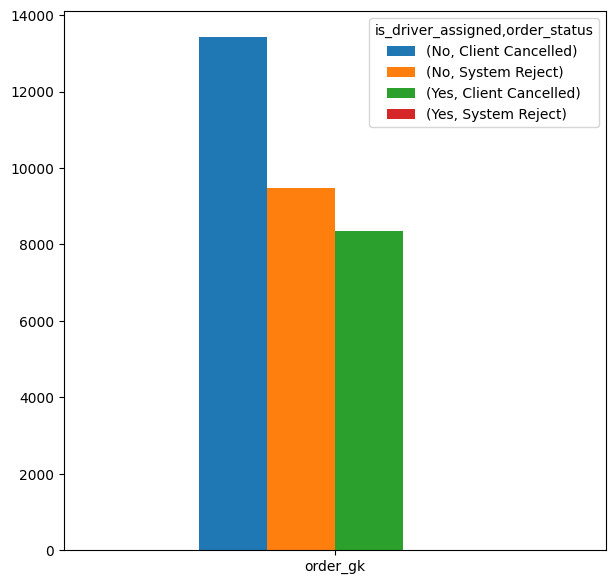

In [14]:
df_q1 = df.pivot_table(columns=["is_driver_assigned", "order_status"], values="order_gk", aggfunc="count")
_ = df_q1.plot(kind="bar", subplots=False, figsize=(7, 7), legend=True, rot=0)

In [15]:
# the structure of the pivot table is very similar to the group-by dataframe
df_q1

is_driver_assigned               No                            Yes  \
order_status       Client Cancelled System Reject Client Cancelled   
order_gk                      13435          9469             8360   

is_driver_assigned                
order_status       System Reject  
order_gk                       4

**Question 2**

**Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?**

This question builds up upon the previous one by delving deeper into the analysis of failed orders. Rather than just plotting the distribution of fails by category (reason for cancellation, and the driver assignment), we want to know when these fails occur, and if there is some specific period in the day when one category prevails over others

In [16]:
# extract hour from the time column
df["order_hour"] = df["order_time"].str.split(":").apply(lambda split: split[0])

In [17]:
# print a small sample to make sure that the transformation is correct
df.sample(n=5, random_state=42)

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,cancellations_time_in_seconds,offer_id,is_driver_assigned,order_status,order_hour
30194,21:15:35,-0.969588,51.455780,299.0,3000555697076,223.0,300050725946,Yes,Client Cancelled,21
14748,10:13:35,-0.955958,51.430362,NaN,3000626091676,91.0,300052014519,No,Client Cancelled,10
29083,09:16:38,-1.033560,51.441967,NaN,3000594099225,68.0,300051458740,No,Client Cancelled,09
16926,02:08:09,-0.967676,51.444489,NaN,3000626980467,125.0,300052031394,No,Client Cancelled,02
21530,21:44:21,-0.972683,51.456762,NaN,3000554421440,11.0,300050671163,No,Client Cancelled,21


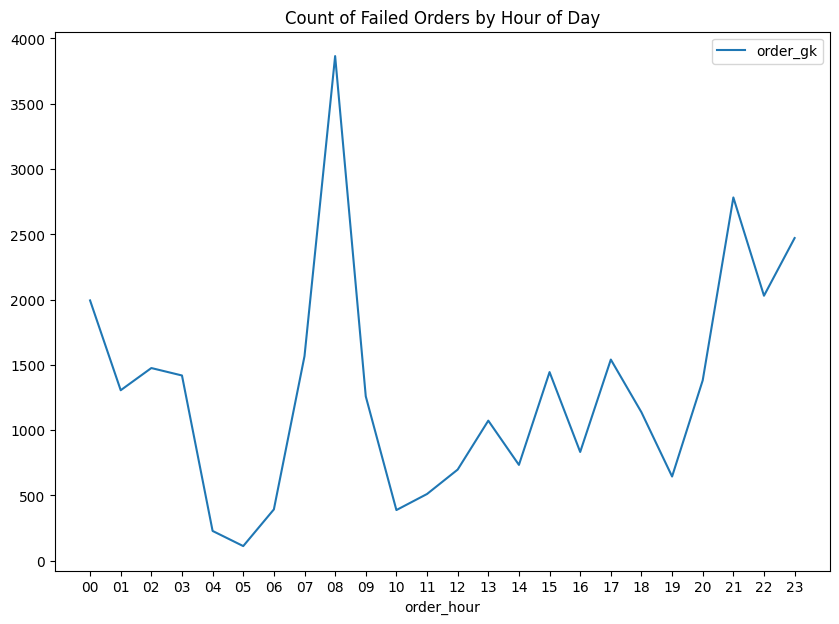

In [18]:
_ = df.groupby(by="order_hour")["order_gk"].count().plot(figsize=(10, 7),
                                                         legend=True,
                                                         xticks=range(0, 24),
                                                         title="Count of Failed Orders by Hour of Day")

As a first step towards a DataFrame that contains such aggregated information we group-by by the order hour, the driver-assigned flag, and the order status, and then count the number of order_gk.

In [19]:
grouped_q2 = df.groupby(by=["order_hour", "is_driver_assigned", "order_status"])["order_gk"].count()
grouped_q2

order_hour  is_driver_assigned  order_status    
00          No                  Client Cancelled     957
                                System Reject        706
            Yes                 Client Cancelled     326
                                System Reject          4
01          No                  Client Cancelled     633
                                                    ... 
22          No                  System Reject        660
            Yes                 Client Cancelled     415
23          No                  Client Cancelled    1144
                                System Reject        883
            Yes                 Client Cancelled     444
Name: order_gk, Length: 73, dtype: int64

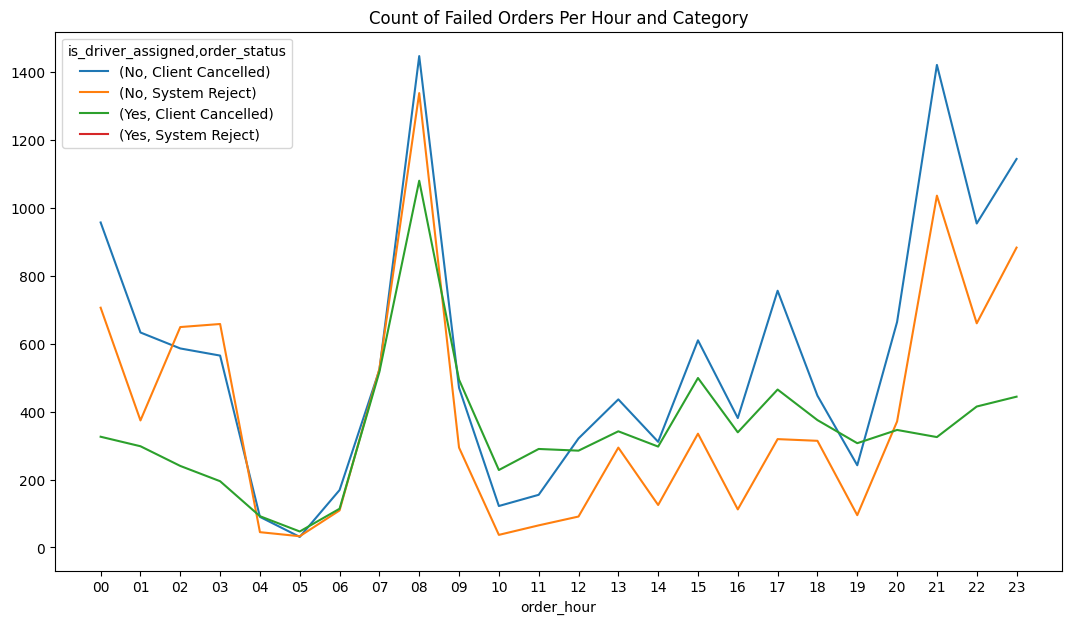

In [20]:
_ = grouped_q2.reset_index().pivot(index="order_hour",
                                   columns=["is_driver_assigned", "order_status"],
                                   values="order_gk").plot(xticks=range(0, 24),
                                                           figsize=(13, 7),
                                                           title="Count of Failed Orders Per Hour and Category")

The four system rejects with the assigned driver occurred around midnight (see the output of the grouped DataFrame). The rest of the categories follow similar distribution, with the client cancellations with the assigned driver having a substantially lower count during the night hours.

**Question 3**

**Plot the average time to cancellation with and without driver, by hour. Can we draw any conclusions from this plot?**

To solve this question we are going to take the same approach as the previous question.

First, we will aggregate the DataFrame by the order hour and the driver-assignment flag. Then, we will aggregate the cancellations_time_in_seconds column with the function mean. This will give us the required, aggregated information.

In [21]:
grouped_q3 = df.groupby(by=["order_hour", "is_driver_assigned"])["cancellations_time_in_seconds"].mean()
grouped_q3

order_hour  is_driver_assigned
00          No                    115.126437
            Yes                   276.082822
01          No                    100.593997
            Yes                   296.312081
02          No                    121.305461
            Yes                   301.466667
03          No                    129.182301
            Yes                   368.682051
04          No                    100.733333
            Yes                   245.250000
05          No                    102.838710
            Yes                   156.617021
06          No                    202.952663
            Yes                   225.508772
07          No                    141.177820
            Yes                   177.640232
08          No                    132.625432
            Yes                   172.896296
09          No                    138.014894
            Yes                   230.821862
10          No                     93.795082
            Yes                   206.447368
11          No                     93.090323
            Yes                   276.793103
12          No                    128.224299
            Yes                   243.000000
13          No                    103.577982
            Yes                   248.301170
14          No                    112.752412
            Yes                   241.367003
15          No                    140.970492
            Yes                   188.380762
16          No                    123.181102
            Yes                   217.126844
17          No                    106.842593
            Yes                   280.782796
18          No                     85.845638
            Yes                   270.277333
19          No                    103.231405
            Yes                   151.039088
20          No                    117.518072
            Yes                   214.517341
21          No                    130.828290
            Yes                   224.443077
22          No                    103.662474
            Yes                   230.720482
23          No                    117.294580
            Yes                   320.189189
Name: cancellations_time_in_seconds, dtype: float64

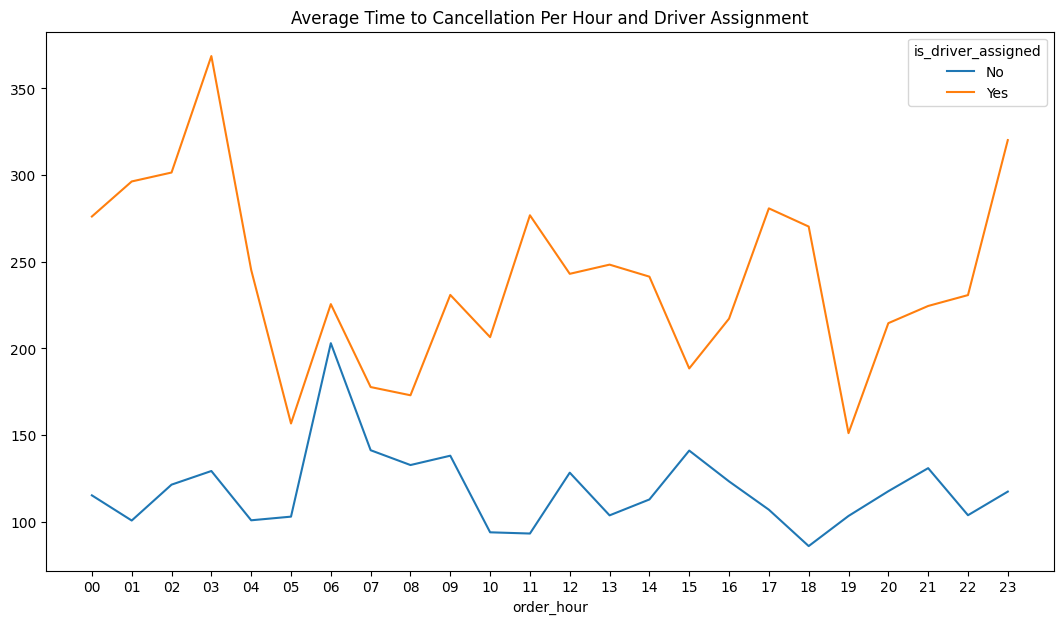

In [22]:
_ = grouped_q3.reset_index().pivot(index="order_hour",
                                   columns="is_driver_assigned",
                                   values="cancellations_time_in_seconds").plot(xticks=range(0, 24),
                                                                                figsize=(13, 7),
                                                                                title="Average Time to Cancellation Per Hour and Driver Assignment")

The average time to cancellation is higher on orders with an assigned driver than without, for each hour without exception. The peak occurs at 3 A.M. At this time there are a lot of client cancellations, so a logical explanation would be that clients have waited too long for the driver.

**Question 4**

**Plot the distribution of average ETA by hours. How can this plot be explained?**

The solution to this question is quite straightforward. We simply group-by the DataFrame on the order hour, and aggregate the m_order_eta column with a mean function. Then, we plot the resulting DataFrame. The result is in the cell immediately below. The line very closely matches the count of failed orders per hour, indicating that the number of failed orders increases as the average waiting time of the client increases.

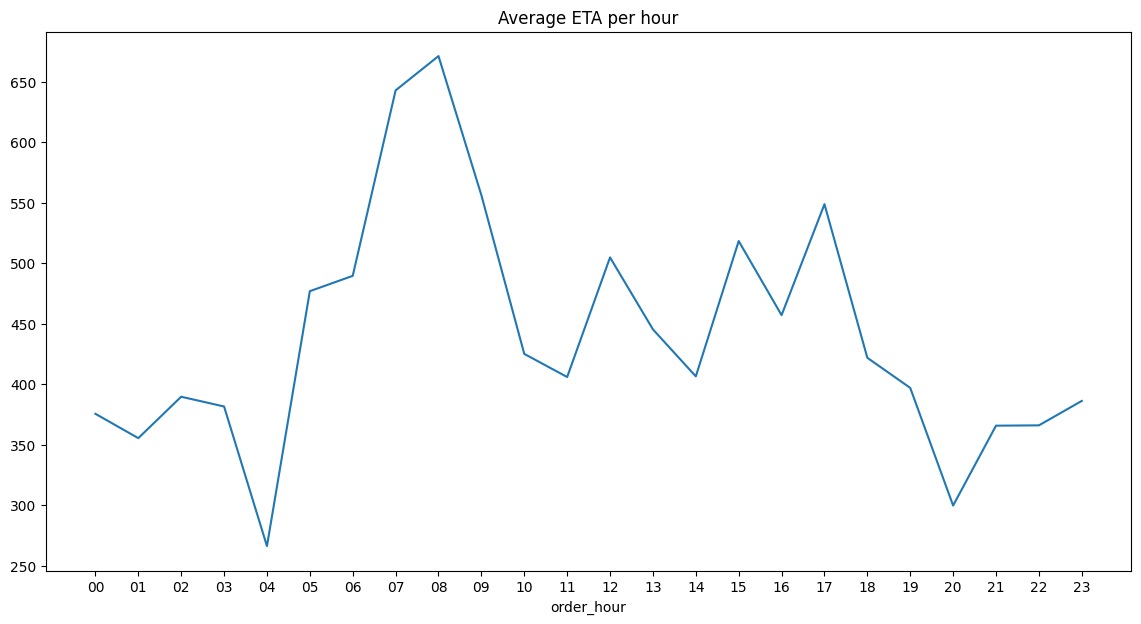

In [23]:
_ = df.groupby(by="order_hour")["m_order_eta"].mean().plot(figsize=(14, 7),
                                                           xticks=range(0, 24),
                                                           title="Average ETA per hour")

**BONUS**:

 **Question 5**

Using the h3 and folium packages, calculate how many size 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.

In [27]:
!pip install h3
import h3
import folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.8 MB/s eta 0:00:00


In [28]:
df["hex_id"] = df.apply(
    func=lambda row: h3.latlng_to_cell(lat=row["origin_latitude"], lng=row["origin_longitude"], res=8), axis=1)

In [29]:
grouped_q5 = df.groupby(by="hex_id")["order_gk"].count()
grouped_q5.shape

(139,)

In [30]:
grouped_q5 = grouped_q5.reset_index()
grouped_q5.sample(n=5, random_state=42)

,hex_id,order_gk
135,88195d74d1fffff,1
66,88195d2a33fffff,12
31,88195d2941fffff,52
118,88195d2b5dfffff,31
42,88195d2961fffff,5


To find the number of hexes that contain 80% of the orders, we will apply a cumulative percentage operation over the order_gk count column in the grouped_q5 DataFrame. This consists of the following steps:

Sort the DataFrame by the count.

Find the total number (sum) of failed orders.

Apply the method cumsum to find the cumulative sum of the order-count column.

Divide by the total sum to generate percentages.

Filter to find the row that is closest to 80%.

In [31]:
grouped_q5 = grouped_q5.sort_values(by="order_gk")  # 1
total_orders = grouped_q5["order_gk"].sum()  # 2
grouped_q5["cum_sum"] = grouped_q5["order_gk"].cumsum()  # 3
grouped_q5["cum_perc"] = 100 * grouped_q5["cum_sum"] / total_orders  # 4
grouped_q5[grouped_q5["cum_perc"] <= 80]  # 5

,hex_id,order_gk,cum_sum,cum_perc
11,88195d282bfffff,1,1,0.003198
38,88195d2953fffff,1,2,0.006396
122,88195d3993fffff,1,3,0.009594
79,88195d2aebfffff,1,4,0.012793
137,88195d74d5fffff,1,5,0.015991
...,...,...,...,...
61,88195d2a27fffff,1295,15628,49.980811
20,88195d284dfffff,1937,17565,56.175643
91,88195d2b19fffff,1960,19525,62.444032
87,88195d2b11fffff,2191,21716,69.451196


There are 137 rows in the final output, and 139 rows in the original grouped DataFrame, meaning that 137 hexagons contain around 80% of data, and only 2 hexagons contain the other 20%!

In [32]:
map = folium.Map(location=[df["origin_latitude"].mean(), df["origin_longitude"].mean()],
                 zoom_start=8.5,  # after a bit of experimentation, we thought this presents the map best
                 tiles="cartodbpositron")

In [35]:
!pip install geojson
import json
import geojson
import h3.api.basic_int as h3  # using the integer-based API

def to_geojson(row):
    """Transform hex_id into a GeoJSON feature."""
    # Convert hex string to integer (required by basic_int API)
    int_cell = int(row["hex_id"], 16)

    # Get boundary in [lat, lng], flip to [lng, lat] for GeoJSON
    latlngs = h3.cell_to_boundary(int_cell)
    lnglats = [[lng, lat] for lat, lng in latlngs]

    geometry = {
        "type": "Polygon",
        "coordinates": [lnglats]
    }

    return geojson.Feature(
        id=row["hex_id"],
        geometry=geometry,
        properties={"order_gk": row["order_gk"]}
    )

# Apply function row-wise and collect GeoJSON features
geojsons = grouped_q5.apply(to_geojson, axis=1).tolist()
geojson_str = json.dumps(geojson.FeatureCollection(geojsons))

In [36]:
import matplotlib

colormap = matplotlib.colormaps["plasma"]  #
max_order_gk = grouped_q5["order_gk"].max()
min_order_gk = grouped_q5["order_gk"].min()

In [37]:
_ = folium.GeoJson(data=geojson_str, style_function=lambda f: {
    "fillColor": matplotlib.colors.to_hex(
        colormap((f["properties"]["order_gk"] - min_order_gk) / (max_order_gk - min_order_gk))),
    "color": "black",
    "weight": 1,
    "fillOpacity": 0.7
}).add_to(map)

In [38]:
map